In [2]:
%load_ext autoreload
%autoreload 2
import config as cfg
import numpy as np
import pandas as pd
import logging
from sca import plots, helpers as h
from sklearn.pipeline import make_pipeline

In [3]:
X, y, pts, ks = h.load_data(cfg.DATA_DIR / 'ascadv_clean.h5', as_df=True)

In [4]:
R = np.load("data/combined_nicv_results.npy")

<Axes: title={'center': 'NICV'}, xlabel='Feature 1', ylabel='Feature 2'>

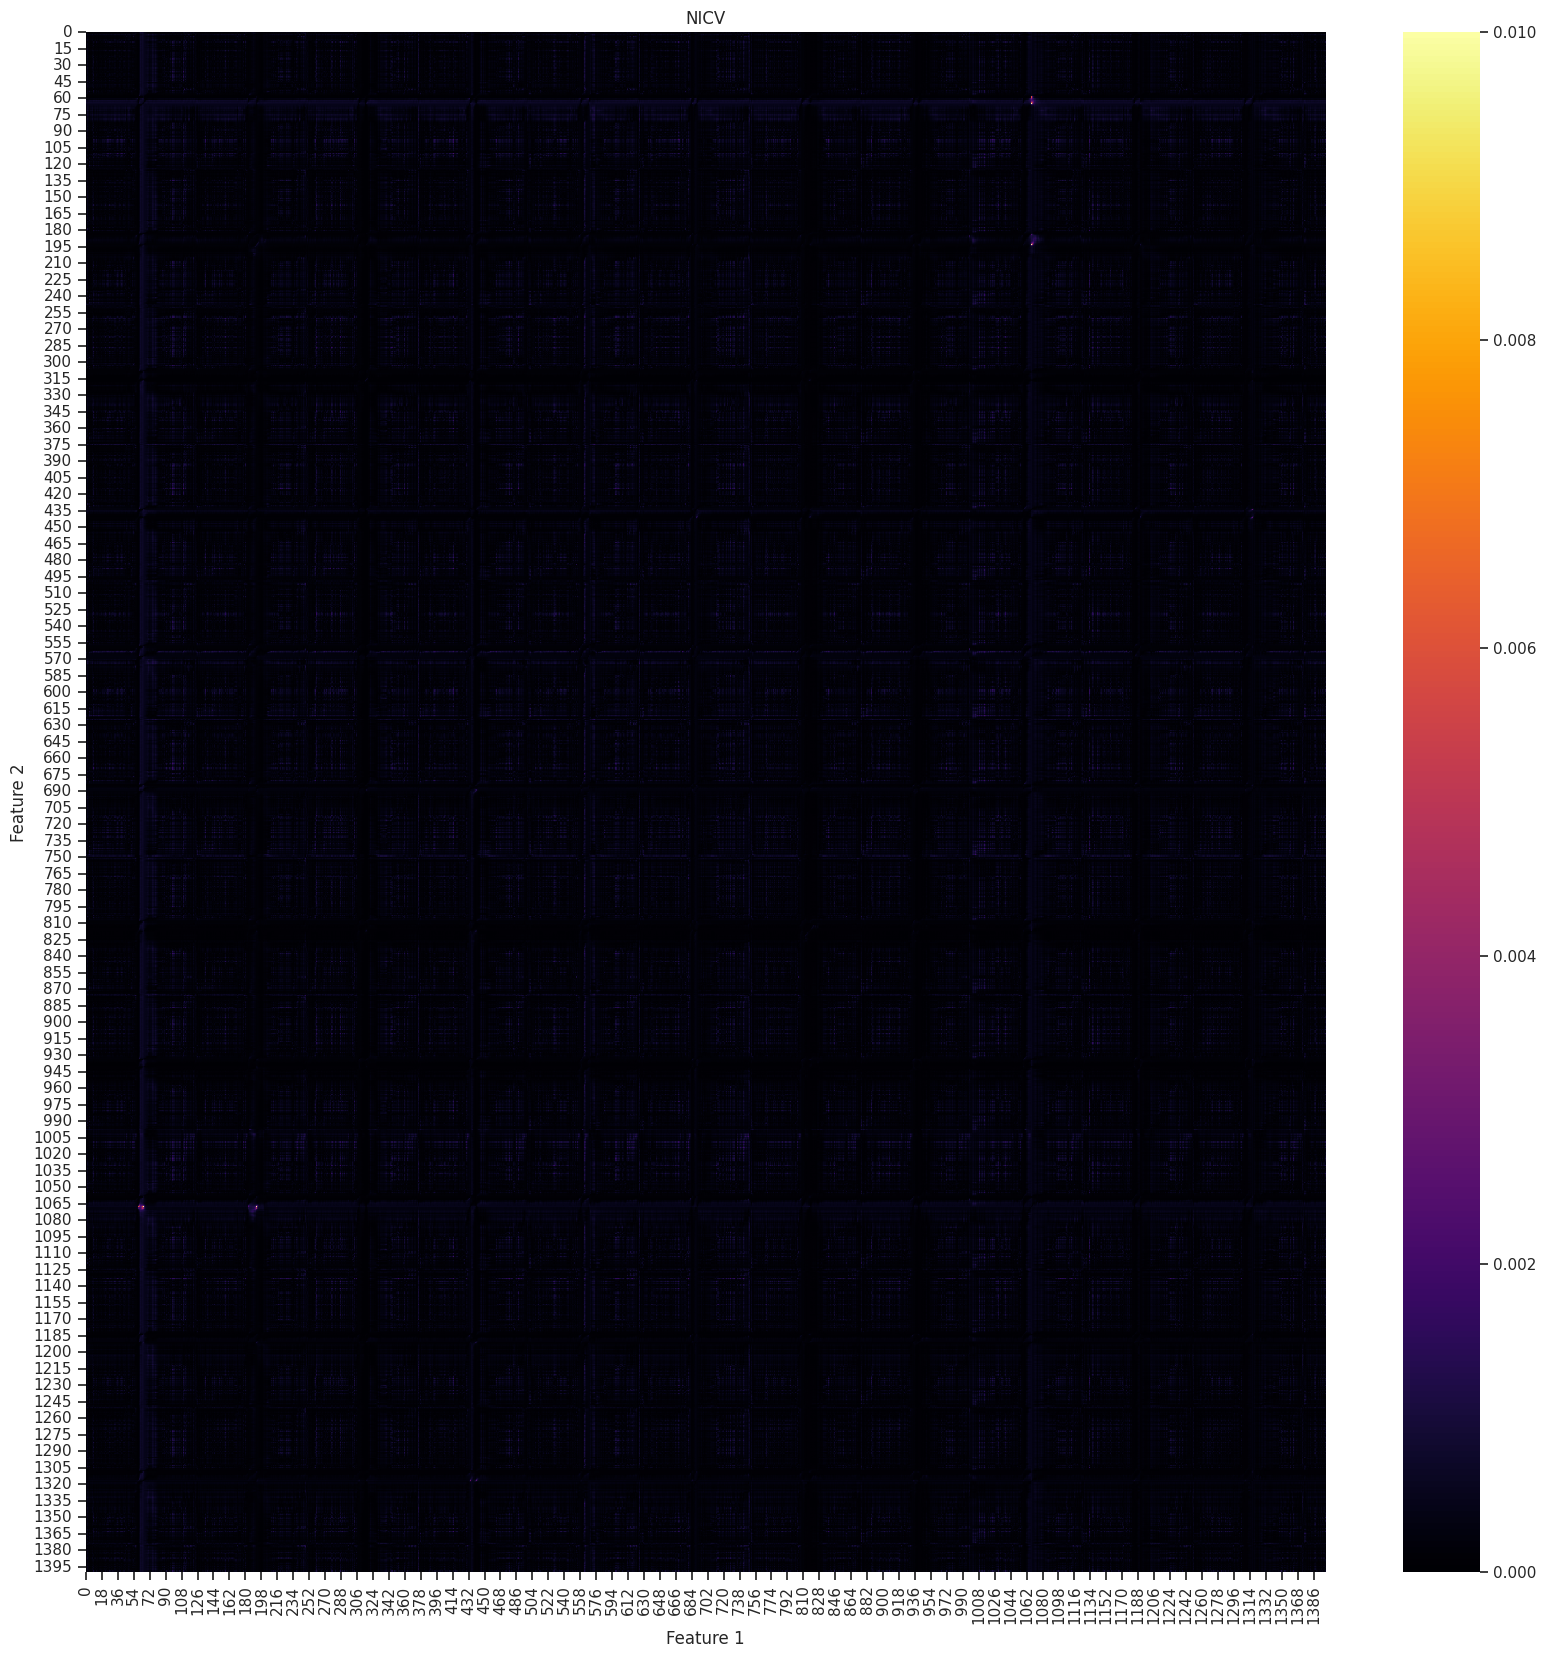

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='ticks')

fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(R, cmap='inferno', vmin=0, vmax=0.01)
plots.labs(ax, xlab="Feature 1", ylab="Feature 2", title="NICV")

In [6]:
idx = np.where(R > 0.004)[0]
idx

array([  59,   60,   64,   64,   65,  192,  193,  193, 1068, 1068, 1068,
       1068, 1068, 1069, 1069, 1069])

In [31]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier as RFC

X_best = X.iloc[:, idx]
scaler = StandardScaler()
# poly = PolynomialFeatures(degree=(2, 2), interaction_only=True, include_bias=False)
rf = RFC(max_depth=10, min_samples_leaf=10, n_jobs=-1, random_state=cfg.SEED)
pl_rf = make_pipeline(scaler, rf)

score = np.mean(h.cv(pl_rf, X_best, y, pts, ks, seed=cfg.SEED))
logging.info(f"Mean PI: {score:.2e}")

00:19:51: [1] Mean PI: 0.005
00:19:58: [2] Mean PI: 0.005


KeyboardInterrupt: 

In [23]:
rf = pl_rf.named_steps['randomforestclassifier']

df_imps = pd.DataFrame({
    'feature': poly.get_feature_names_out(X_best.columns), 
    'importance': rf.feature_importances_
})
df_imps = df_imps.sort_values(by='importance', ascending=False)
df_imps["feature"] = df_imps["feature"].str.replace(r"^([^ ^]+)\^[^ ^]+$", r"\1 \1", regex=True)
df_imps[["feat1", "feat2"]] = df_imps["feature"].str.split(" ", n=1, expand=True)
df_imps = df_imps.drop(columns=['feature'])
df_imps

,importance,feat1,feat2
9,0.174994,193,1068
3,0.135434,59,1068
6,0.110024,64,1068
2,0.108914,59,193
8,0.106143,65,1068
5,0.086220,64,193
7,0.079478,65,193
1,0.074392,59,65
0,0.070963,59,64
4,0.053438,64,65


In [38]:
import scipy.stats

hw_pt = np.bitwise_count(pts.iloc[:, 0])

corr_64, _ = scipy.stats.pearsonr(X['64'], hw_pt)
corr_1070, _ = scipy.stats.pearsonr(X['1070'], hw_pt)

print(f"t=64 correlation with plaintext: {corr_64:.4f}")
print(f"t=1070 correlation with plaintext: {corr_1070:.4f}")

t=64 correlation with plaintext: 0.0008
t=1070 correlation with plaintext: 0.0045
